# Transfer Learning with TensorFlow Part 3: Scaling up

In [4]:
# Creating helper functions
!wget https://raw.githubusercontent.com/LucasCarmusciano/TensorFlow-Practice/main/extras/helper_functions.py

--2024-01-11 19:51:25--  https://raw.githubusercontent.com/LucasCarmusciano/TensorFlow-Practice/main/extras/helper_functions.py
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.109.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 10245 (10K) [text/plain]
Grabando a: «helper_functions.py.1»

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    en 0s      

2024-01-11 19:51:25 (22.8 MB/s) - «helper_functions.py.1» guardado [10245/10245]



In [5]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

The goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-11 19:46:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 142.251.134.91, 216.58.202.91, 142.250.79.155, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[142.251.134.91]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 1625420029 (1.5G) [application/zip]
Grabando a: «101_food_classes_10_percent.zip»

101_food_classes_10 100%[===================>]   1.51G  9.23MB/s    en 2m 50s  

2024-01-11 19:49:23 (9.10 MB/s) - «101_food_classes_10_percent.zip» guardado [1625420029/1625420029]



In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 1 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Steps I'm going to take

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")  

In [12]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [15]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 141s 587ms/step - loss: 3.1572 - accuracy: 0.3187 - val_loss: 2.4442 - val_accuracy: 0.4439
Epoch 2/5
237/237 [==============================] - 146s 616ms/step - loss: 2.1465 - accuracy: 0.5065 - val_loss: 2.0533 - val_accuracy: 0.4979
Epoch 3/5
237/237 [==============================] - 156s 660ms/step - loss: 1.7938 - accuracy: 0.5743 - val_loss: 1.9059 - val_accuracy: 0.5140
Epoch 4/5
237/237 [==============================] - 156s 660ms/step - loss: 1.5844 - accuracy: 0.6172 - val_loss: 1.8125 - val_accuracy: 0.5289
Epoch 5/5
237/237 [==============================] - 156s 660ms/step - loss: 1.4292 - accuracy: 0.6506 - val_loss: 1.7655 - val_accuracy: 0.5392


In [16]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 339s 429ms/step - loss: 1.5909 - accuracy: 0.5788


[1.5908658504486084, 0.5788118839263916]

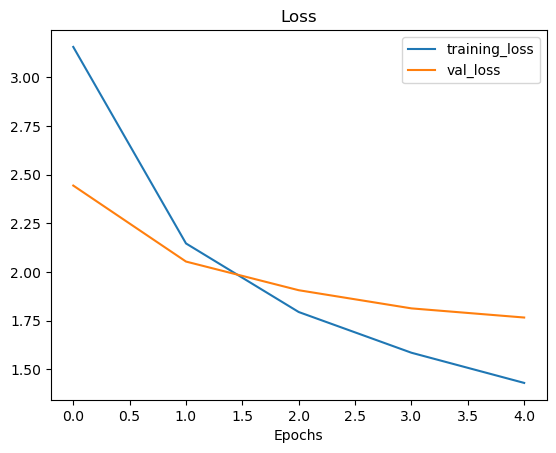

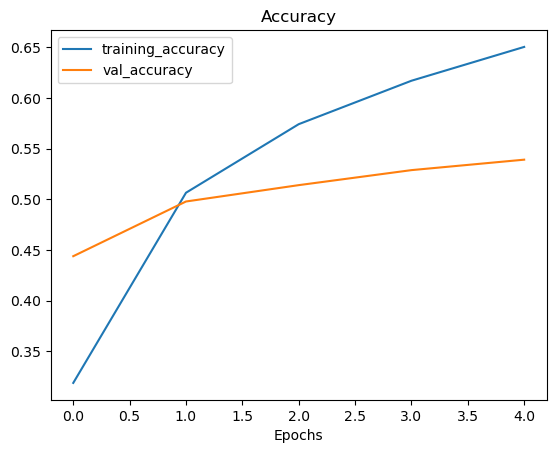

In [17]:
plot_loss_curves(history_all_classes_10_percent)

**⚠️OVERFITTING⚠️**

---
## Fine-tuning

In [25]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [26]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [27]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [31]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])     

In [32]:
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=10, # Fine-tune for 5 more epochs
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 142s 591ms/step - loss: 1.2003 - accuracy: 0.6853 - val_loss: 1.7339 - val_accuracy: 0.5387
Epoch 6/10
237/237 [==============================] - 148s 624ms/step - loss: 1.0797 - accuracy: 0.7159 - val_loss: 1.7221 - val_accuracy: 0.5466
Epoch 7/10
237/237 [==============================] - 150s 632ms/step - loss: 1.0082 - accuracy: 0.7306 - val_loss: 1.7103 - val_accuracy: 0.5522
Epoch 8/10
237/237 [==============================] - 161s 680ms/step - loss: 0.9335 - accuracy: 0.7514 - val_loss: 1.7267 - val_accuracy: 0.5508
Epoch 9/10
237/237 [==============================] - 158s 665ms/step - loss: 0.8840 - accuracy: 0.7589 - val_loss: 1.7409 - val_accuracy: 0.5503
Epoch 10/10
237/237 [==============================] - 154s 649ms/step - loss: 0.8250 - accuracy: 0.7797 - val_loss: 1.7101 - val_accuracy: 0.5546


In [33]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 327s 414ms/step - loss: 1.5044 - accuracy: 0.5996


[1.5043892860412598, 0.5996039509773254]

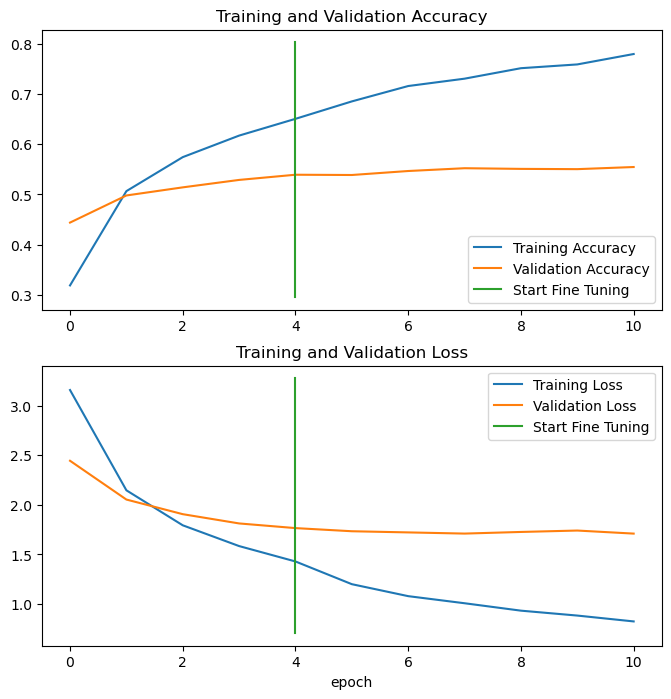

In [34]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Making predictions with trained model

In [36]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 291s 367ms/step


In [37]:
len(preds_probs)

25250

That is because the model has 790 batches of 32 images... 

790*32 = 25280 (the last batch has only 2 images)

In [43]:
preds_probs.shape

(25250, 101)

In [45]:
preds_probs[0]

array([1.27911538e-01, 3.19085288e-04, 9.21651870e-02, 5.65659057e-08,
       3.15489820e-06, 1.29525426e-06, 1.40289863e-04, 9.60503075e-06,
       1.01655545e-02, 1.04414625e-03, 9.06533387e-07, 6.19778530e-06,
       7.50911480e-04, 3.26267667e-07, 1.13706999e-02, 1.68680574e-03,
       1.09271714e-05, 1.31075236e-03, 1.04286699e-02, 2.27624550e-05,
       2.45845784e-03, 1.84972032e-05, 3.90670844e-04, 1.23445192e-04,
       1.25496788e-03, 3.54172918e-03, 7.16793351e-04, 2.85566693e-05,
       2.72783995e-01, 6.27576699e-03, 6.76155514e-06, 4.78690956e-04,
       6.65830448e-04, 1.02441936e-06, 2.22870824e-03, 1.62137567e-05,
       7.18997180e-05, 1.17791945e-03, 6.32060170e-02, 5.41306035e-05,
       3.15709709e-04, 8.29519890e-03, 4.71102394e-04, 8.42459121e-06,
       1.66515412e-04, 2.05128072e-05, 4.08917153e-03, 2.22179733e-04,
       1.62798460e-06, 6.91174641e-02, 2.09760168e-04, 3.63620893e-05,
       1.95538327e-02, 8.41944367e-02, 1.05141822e-04, 9.89073329e-03,
      

In [56]:
sum = 0
for i in preds_probs[0]:
        sum = i + sum
print(sum)

1.0000000265150923


In [65]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
print(pred_classes[:10]), print(len(pred_classes))

[28  0  0  8  8 78 29 46  9  0]
25250


(None, None)

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [66]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

That's because the data is in order in test_data... I put **shuffle = False**

## Evaluating our model's predictions

One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (`y_labels`) is to find the accuracy score.

In [68]:
all_classes_10_percent_fine_tune_results

[1.5043892860412598, 0.5996039509773254]

In [70]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.5996039603960396

### Let's get visual with a confusion matrix

In [71]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [72]:
from helper_functions import make_confusion_matrix

In [73]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [74]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

### Classification report

Let's make a report with the classification evaluating methods...

<table style="font-size: 17px;">
  <tr>
    <th style="text-align: center;">Metric Name</th>
    <th style="text-align: center;">Metric Formula</th> 
    <th style="text-align: center;">Code</th>
  </tr>
  <tr>
    <td style="text-align: center;">Accuracy</td>
    <td style="text-align: center;">(tp + tn)/(tp + tn + fp + fn)</td> 
    <td style="text-align: center;">tf.keras.metrics.Accuracy() or sklearn.metrics.accuracy_score()</td>
  </tr>
  <tr>
    <td style="text-align: center;">Precision</td>
    <td style="text-align: center;">tp/(tp+fp)</td> 
    <td style="text-align: center;">tf.keras.metrics.Precision() or sklearn.metrics.precision_score()</td>
  </tr>
  <tr>
    <td style="text-align: center;">Recall</td>
    <td style="text-align: center;">tp/(tp+fn)</td> 
    <td style="text-align: center;">tf.keras.metrics.Recall() or sklearn.metrics.recall_score()</td>
  </tr>
  <tr>
    <td style="text-align: center;">F1-score</td>
    <td style="text-align: center;">(2 * precision * recall)/(precision + recall)</td> 
    <td style="text-align: center;">sklearn.metrics.f1_score()</td>
  </tr>
  <tr>
    <td style="text-align: center;">Confusion matrix</td>
    <td style="text-align: center;">NA</td>
    <td style="text-align: center;">Custom function or sklearn.metrics.confusion_matrix()</td>
  </tr>
</table>

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.19      0.24       250
           1       0.49      0.74      0.59       250
           2       0.67      0.60      0.64       250
           3       0.88      0.46      0.60       250
           4       0.51      0.47      0.49       250
           5       0.44      0.45      0.45       250
           6       0.74      0.80      0.77       250
           7       0.82      0.74      0.78       250
           8       0.25      0.52      0.34       250
           9       0.32      0.75      0.45       250
          10       0.57      0.38      0.46       250
          11       0.79      0.58      0.67       250
          12       0.63      0.62      0.62       250
          13       0.62      0.50      0.55       250
          14       0.57      0.54      0.55       250
          15       0.46      0.34      0.39       250
          16       0.73      0.49      0.59       250
          17       0.29    

Let's plot all F1-scores...

In [77]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.32432432432432434,
  'recall': 0.192,
  'f1-score': 0.2412060301507538,
  'support': 250},
 '1': {'precision': 0.49076517150395776,
  'recall': 0.744,
  'f1-score': 0.5914149443561209,
  'support': 250},
 '2': {'precision': 0.6711111111111111,
  'recall': 0.604,
  'f1-score': 0.6357894736842106,
  'support': 250},
 '3': {'precision': 0.8769230769230769,
  'recall': 0.456,
  'f1-score': 0.6,
  'support': 250},
 '4': {'precision': 0.5130434782608696,
  'recall': 0.472,
  'f1-score': 0.49166666666666664,
  'support': 250},
 '5': {'precision': 0.4444444444444444,
  'recall': 0.448,
  'f1-score': 0.44621513944223107,
  'support': 250},
 '6': {'precision': 0.7352941176470589,
  'recall': 0.8,
  'f1-score': 0.7662835249042146,
  'support': 250},
 '7': {'precision': 0.8157894736842105,
  'recall': 0.744,
  'f1-score': 0.7782426778242678,
  'support': 250},
 '8': {'precision': 0.2549407114624506,
  'recall': 0.516,
  'f1-score': 0.3412698412698412,
  'support': 250},
 '9':

In [81]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2412060301507538,
 'baby_back_ribs': 0.5914149443561209,
 'baklava': 0.6357894736842106,
 'beef_carpaccio': 0.6,
 'beef_tartare': 0.49166666666666664,
 'beet_salad': 0.44621513944223107,
 'beignets': 0.7662835249042146,
 'bibimbap': 0.7782426778242678,
 'bread_pudding': 0.3412698412698412,
 'breakfast_burrito': 0.4468339307048984,
 'bruschetta': 0.46043165467625896,
 'caesar_salad': 0.6697459584295612,
 'cannoli': 0.6247464503042596,
 'caprese_salad': 0.5518763796909493,
 'carrot_cake': 0.5503080082135524,
 'ceviche': 0.39080459770114945,
 'cheese_plate': 0.5885167464114832,
 'cheesecake': 0.37268847795163584,
 'chicken_curry': 0.47876447876447875,
 'chicken_quesadilla': 0.6532438478747203,
 'chicken_wings': 0.7347740667976426,
 'chocolate_cake': 0.5493230174081237,
 'chocolate_mousse': 0.36781609195402304,
 'churros': 0.7390396659707723,
 'clam_chowder': 0.7048458149779736,
 'club_sandwich': 0.698901098901099,
 'crab_cakes': 0.41720430107526885,
 'creme_brulee': 0.7625

In [84]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores[:10]

,class_names,f1-score
33,edamame,0.959064
63,macarons,0.891720
75,pho,0.854871
69,oysters,0.854701
91,spaghetti_carbonara,0.834879
86,sashimi,0.833006
68,onion_rings,0.832653
32,dumplings,0.828402
65,mussels,0.823770
45,frozen_yogurt,0.821803


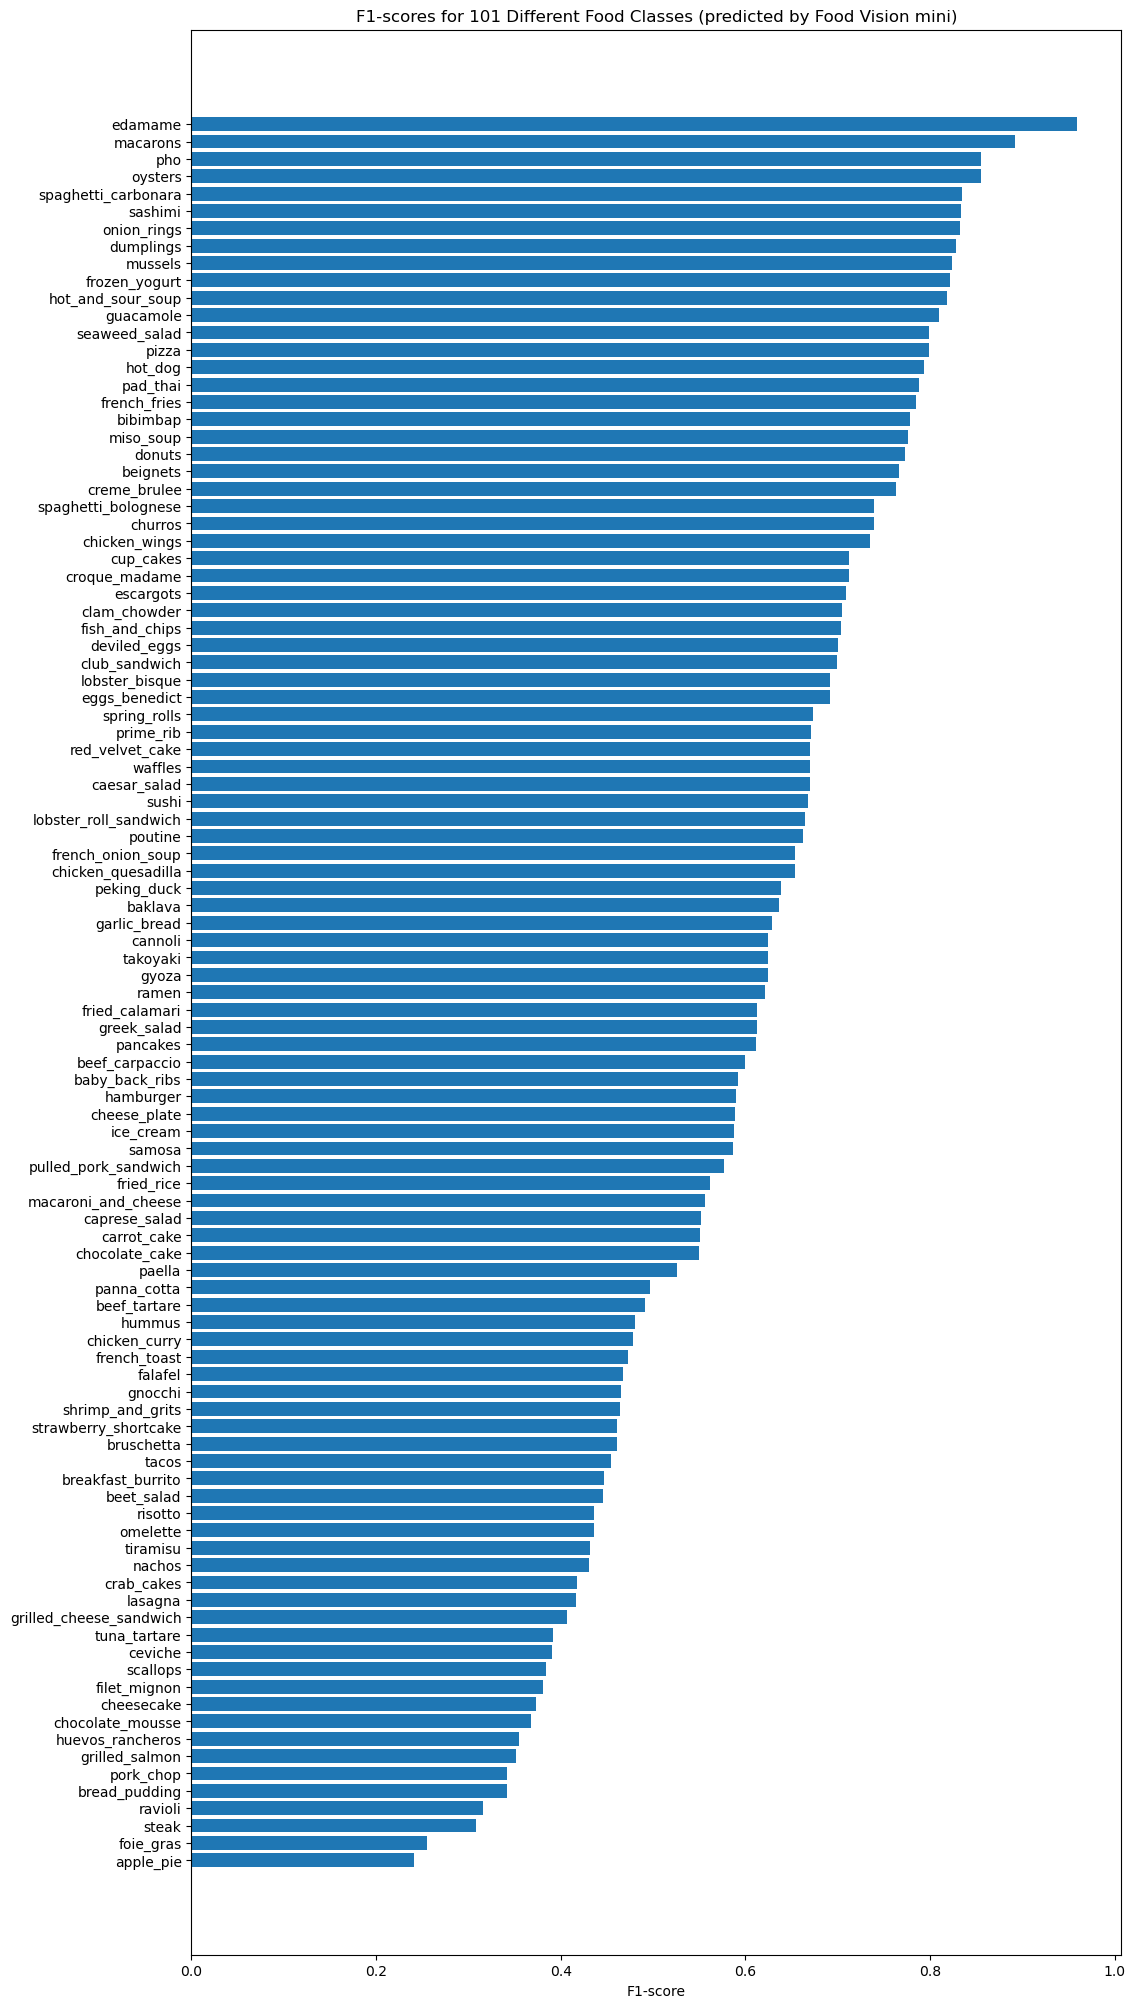

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot